In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!ls

__notebook_source__.ipynb


In [4]:
import cudf as pd
import cupy as np
import matplotlib.pyplot as plt
from cuml.model_selection import train_test_split
from tqdm import tqdm
from keras.preprocessing import image

%matplotlib inline

In [5]:
train = pd.read_csv('../input/state-farm-distracted-driver-detection/driver_imgs_list.csv')    # reading the csv file
train.head() 

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


# Image dataset loading  
### For ML models we put target image size as 64x64 across 3 channels (R,G,B) and flatten the matrix to give 1D array which ML Models expects.
### Image api of Keras is used for dataset loading.

In [6]:
train_image = []
for i in tqdm(range(train.shape[0])):
    img = image.load_img('../input/state-farm-distracted-driver-detection/imgs/train/'+train["classname"][i]+"/"+train["img"][i],target_size=(64,64,3))
    img = image.img_to_array(img).flatten()
    img = img/255
    train_image.append(img)
X = np.array(train_image)

100%|██████████| 22424/22424 [06:17<00:00, 59.39it/s]


## Encoding Classnames

In [7]:
factor = pd.factorize(train['classname'])
y = factor[0]
definitions = factor[1]
print(y)
print(definitions)

[0 0 0 ... 9 9 9]
StringIndex(['c0' 'c1' 'c2' 'c3' 'c4' 'c5' 'c6' 'c7' 'c8' 'c9'], dtype='object')


## Checking for class Imbalance in dataset


c0    2489
c3    2346
c4    2326
c6    2325
c2    2317
c5    2312
c1    2267
c9    2129
c7    2002
c8    1911
Name: classname, dtype: int32


<AxesSubplot:>

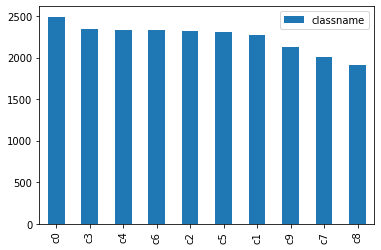

In [6]:
print(train['classname'].value_counts())
pd.DataFrame(train['classname'].value_counts()).to_pandas().plot(kind='bar')

# Image Quality Assessment using Brisque Score

In [9]:
from libsvm import svmutil
!pip install pybrisque
from brisque import *

In [10]:
brisq = BRISQUE()

In [11]:
from tqdm import tqdm
scores=[]
l=[]
for i in tqdm(range(train.shape[0])):
    temp=brisq.get_score('../input/state-farm-distracted-driver-detection/imgs/train/'+train["classname"][i]+"/"+train["img"][i])
    l.append((train["img"][i],temp))
    scores.append(temp)

100%|██████████| 22424/22424 [22:32<00:00, 16.58it/s]


In [12]:
import statistics
statistics.mean(scores)

33.0189346624042

##### since BRISQUE score is less so dataset images are of high quality.

(array([2.0000e+00, 9.0000e+00, 9.6800e+02, 1.3225e+04, 6.1350e+03,
        1.1920e+03, 6.4700e+02, 2.1100e+02, 2.2000e+01, 1.3000e+01]),
 array([ 2.49684518, 10.21149825, 17.92615133, 25.64080441, 33.35545749,
        41.07011056, 48.78476364, 56.49941672, 64.2140698 , 71.92872287,
        79.64337595]),
 <BarContainer object of 10 artists>)

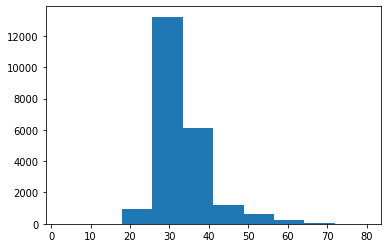

In [13]:
import matplotlib.pyplot as plt
plt.hist(scores)

In [14]:
X.shape

(22424, 12288)

# Train-Test Split 

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [16]:
from cuml.naive_bayes import GaussianNB
from cuml.linear_model import LogisticRegression
from cuml.svm import SVC

# Logistic Regression

In [17]:
clf_lr = LogisticRegression()
clf_lr.fit(X_train, y_train)
import cuml
preds= clf_lr.predict(X_test)
cu_score = cuml.metrics.accuracy_score( y_test, preds )
print(cu_score)

[W] [07:13:27.664432] L-BFGS: max iterations reached
[W] [07:13:27.665446] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
0.9946476221084595


# Gaussian Naive Bias

In [18]:
clf_gnb = GaussianNB()
clf_gnb.fit(X_train, y_train)
import cuml
preds= clf_gnb.predict(X_test)
cu_score = cuml.metrics.accuracy_score( y_test, preds )
print(cu_score)

0.5548617243766785


# Support Vector Classifier

In [19]:
clf_svc = SVC(probability=True)
clf_svc.fit(X_train, y_train)

SVC()

# Predicting Probability of Each Class

In [20]:
preds_prob= clf_svc.predict_proba(X_test)

In [21]:
preds_prob[0]

array([4.27944604e-06, 6.55315253e-05, 5.98455208e-13, 9.83435342e-01,
       1.64947618e-02, 8.54532233e-08, 1.74258853e-18, 1.16612735e-19,
       2.59800031e-17, 5.69817575e-13])

# Predicting Best class for Accuracy metric

In [22]:
import cuml
preds= clf_svc.predict(X_test)
cu_score = cuml.metrics.accuracy_score( y_test, preds )
print(cu_score)

0.9924174547195435


In [23]:
preds

array([3, 5, 7, ..., 6, 6, 6], dtype=int8)

## Calculating Confusion Metric

In [24]:
from cuml.metrics import confusion_matrix
cm=confusion_matrix(y_test.astype("int32"),preds.astype("int32"))

<AxesSubplot:>

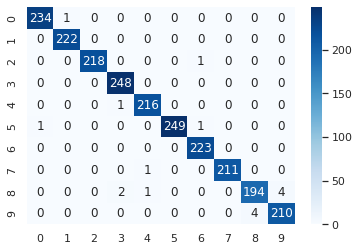

In [26]:
import seaborn as sns
import cupy as np
sns.set(font_scale=1.0)
sns.heatmap(np.asnumpy(cm),annot=True, cmap='Blues',fmt='g')

## XGBoost ,CatBoost, LightGbm, Random Forest & their Ensemble

In [11]:
import xgboost as xgb
import cuml
xgb_clf = xgb.XGBClassifier(use_label_encoder=False,tree_method='gpu_hist')
xgb_clf.fit(X_train, y_train)
preds_prob_xgb=xgb_clf.predict_proba(X_test)
preds= xgb_clf.predict(X_test)
cu_score = cuml.metrics.accuracy_score( y_test, preds )
print(cu_score)

0.9968777894973755


In [13]:
from catboost import CatBoostClassifier
cgb_clf = CatBoostClassifier(iterations=500,learning_rate =0.01,
                           task_type="GPU",metric_period=100,
                           random_seed=42)
cgb_clf.fit(np.asnumpy(X_train),np.asnumpy(y_train))
preds_prob_cgb=cgb_clf.predict_proba(np.asnumpy(X_test))
preds= cgb_clf.predict(np.asnumpy(X_test))
cu_score = cuml.metrics.accuracy_score( y_test, preds )
print(cu_score)

0:	learn: 2.2909138	total: 294ms	remaining: 2m 26s
100:	learn: 1.7896985	total: 23s	remaining: 1m 30s
200:	learn: 1.4922903	total: 47.7s	remaining: 1m 11s
300:	learn: 1.2451341	total: 1m 14s	remaining: 49s
400:	learn: 1.0507340	total: 1m 40s	remaining: 24.9s
499:	learn: 0.9036528	total: 2m 6s	remaining: 0us
0.9045495390892029


In [14]:
import lightgbm as lgb
lgb_clf = lgb.LGBMClassifier(boosting_type='dart',learning_rate=0.18, max_depth=7,
               n_estimators=450,objective='binary',device='gpu',
               random_state=42)
lgb_clf.fit(np.asnumpy(X_train),np.asnumpy(y_train))
preds_prob_lgb=lgb_clf.predict_proba(np.asnumpy(X_test))
preds= lgb_clf.predict(np.asnumpy(X_test))
cu_score = cuml.metrics.accuracy_score( y_test, preds )
print(cu_score)

0.997769832611084


In [15]:
from cuml.ensemble import RandomForestClassifier
rdf_clf=RandomForestClassifier(n_estimators=600,random_state=42, verbose=0,warm_start=False)
rdf_clf.fit(X_train, y_train)
preds_prob_rdf=rdf_clf.predict_proba(X_test)
preds= rdf_clf.predict(X_test)
cu_score = cuml.metrics.accuracy_score( y_test, preds )
print(cu_score)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:794: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams==1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)


0.9799286127090454


# Ensemble
#### *Note - had memory allocation problems in ensembling can be implemented as below on gpu with greater memory 

In [17]:
from sklearn.ensemble import  VotingClassifier
eclf1 = VotingClassifier(estimators=[('catboost', cgb_clf), ('xgboost', xgb_cl), ('lightgbm', lgb_clf),('randomforest', rdf_clf)], voting='soft',weights=[3,2,3,3],flatten_transform=True)
eclf1 = eclf1.fit(np.asnumpy(X_train),np.asnumpy(y_train))

0:	learn: 2.2909138	total: 430ms	remaining: 3m 34s
100:	learn: 1.7896983	total: 23.3s	remaining: 1m 32s
200:	learn: 1.4922903	total: 48.3s	remaining: 1m 11s
300:	learn: 1.2451339	total: 1m 14s	remaining: 49.3s
400:	learn: 1.0507343	total: 1m 41s	remaining: 25.1s
499:	learn: 0.9036528	total: 2m 7s	remaining: 0us
[08:43:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:794: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams==1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)


In [18]:
preds= eclf1.predict(np.asnumpy(X_test))
cu_score = cuml.metrics.accuracy_score( y_test, preds )
print(cu_score)

0.997769832611084


In [19]:
eclf1.predict_proba(np.asnumpy(X_test))[0]

array([0.03971123, 0.03620501, 0.04660262, 0.71179312, 0.03948689,
       0.0149805 , 0.03547675, 0.02047471, 0.02855964, 0.02670954])

In [30]:
test = pd.read_csv('../input/state-farm-distracted-driver-detection/sample_submission.csv')    # reading the csv file
test.head() 


,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
1,img_10.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2,img_100.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
3,img_1000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
4,img_100000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


In [ ]:
test_image = []
for i in tqdm(range(test.shape[0])):
    img = image.load_img('../input/state-farm-distracted-driver-detection/imgs/test/'+test["img"][i],target_size=(64,64,3))
    img = image.img_to_array(img).flatten()
    img = img/255
    test_image.append(img)
test_data = np.array(test_image)

100%|██████████| 79726/79726 [17:21<00:00, 76.56it/s]


In [ ]:
preds=eclf1.predict_proba(np.asnumpy(test_data))